In [ ]:
# you may have to install a few packages
# !pip install seaborn #visulatization package
# !pip install xgboost #xgboots package
# follows GarretCGraham and Yuhan Rao's example - https://github.com/geo-rao

In [1]:
# Import all of the libraries that we'll be using.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn
import xgboost as xgb

# Import additional modules, objects, and functions that we'll use.
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [4]:
df_data = pd.read_csv('NC_L8_GroundTruth.csv', index_col=None)
df_data

# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
df_data = df_data.drop(labels=["Unnamed: 0"], axis="columns")

# Isolate the data and the target values from the dataframe.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.
y_merged = np.array([i if i < 2 else i-1 for i in y]) # Merge corn and soy into single class.

# Define a list of the class names.
multiclass_labels_list = ["forest", "corn/soy", "urban", "water"] 

df_data

,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,35.520636,-82.853181,0,148,181,534,265,3320,1457
...,...,...,...,...,...,...,...,...,...
2370,35.664357,-82.338903,4,247,283,326,255,292,226
2371,35.479572,-82.536076,4,200,256,382,230,169,107
2372,35.481528,-82.534446,4,204,254,423,242,641,300
2373,35.663379,-82.338903,4,268,308,364,298,326,252


In [3]:
# Define the parameter ranges, over which the grid search algorithm will scan, 
# for the number of estimators (ie, the number of decision trees) in the random forest.
# We will try 25, 50, 100 and 200 trees.
N_ESTIMATORS = [25, 50, 100, 200,]

# Define the range of max tree depths over which to search. We will have the
# grid search check trees of depths 5, 10, 50 and also allow it to grow trees in
# an unrestrained manner. In scikit-learn, unrestrained tree growth is the
# default option and is indicated by including None as an argument.
MAX_DEPTH = [5, 10, 50, None]

# Take the two parameter lists we defined above and include them in a parameter
# grid that will be fed to scklearn's GridSearchCV object for hyperparameter
# optimization. See the following site for an example of such a parameter grid:
# https://scikit-learn.org/stable/modules/grid_search.html
# Know that the keywords of the parameter grid dictionaries are the names of the
# keyword arguments taken by the classifiers that we're optimizing.
param_grid = [
    {
        "n_estimators":N_ESTIMATORS,
        "max_depth":MAX_DEPTH,
    }
]

# Define a GridSearchCV object that will optimize a random forest classfier over
# our previously defined parameter grid. Set the grid search object to use 5-fold
# cross-validation and to take advantage of all of the available processors for
# running the search.
gridsearch_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Run the search on the features and the merged classes.
gridsearch_rf.fit(X, y_merged)

# Print the best parameters from the grid search and the best score.
print("Best parameters:", gridsearch_rf.best_params_)
print("Best score:", gridsearch_rf.best_score_)


Best parameters: {'max_depth': 10, 'n_estimators': 25}
Best score: 0.8088421052631579


In [5]:
# Define a GridSearchCV object that takes an XGBoost classifier, instead of a
# random forest, as the model to optimize. Set that classifier's learning rate
# to 0.3, in order to match the default value for the R version of XGBoost 
# (neither Douglas nor I know the reason they have two distinct default learning
# rates).
gridsearch_xgb = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3),
    param_grid,
    cv=5,
    n_jobs=-1,
)

# Run the search on the features and the merged classes.
gridsearch_xgb.fit(X, y_merged)

# Print the best parameters from the grid search and the best score.
print("Best parameters:", gridsearch_xgb.best_params_)
print("Best score:", gridsearch_xgb.best_score_)

Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: 0.8058947368421052


In [6]:
# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(**gridsearch_rf.best_params_)

# Initialize an XGB classifier object with the best hyperparameter 
# sets from the grid search.
xgb_classifier = xgb.XGBClassifier(**gridsearch_xgb.best_params_)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
classification_predictions_xgb = list()
for train, test in stratified_kfold_generator.split(X, y_merged):

    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y_merged[train].ravel())
    xgb_classifier.fit(X[train], y_merged[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])
    y_predicted_xgb = xgb_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y_merged[test].ravel(), y_predicted_rf.ravel()))
    classification_predictions_xgb.append((y_merged[test].ravel(), y_predicted_xgb.ravel()))

C:\Users\HendrikHamann\AppData\Local\Temp\ipykernel_21320\521061593.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


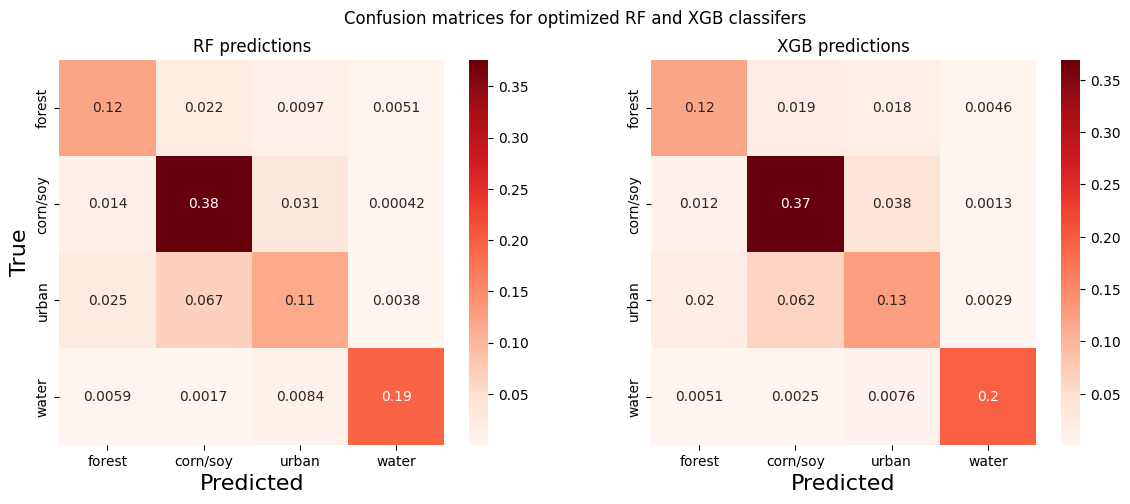

In [7]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((4,4))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)
cf_xgb = calculate_normalized_conf_matrix(classification_predictions_xgb)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the XGBoost confusion matrix.
seaborn.heatmap(
    cf_xgb, cmap="Reds", annot=True, square=True,
    xticklabels=multiclass_labels_list, yticklabels=multiclass_labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
ax[0].set_title("RF predictions")
ax[1].set_title("XGB predictions")

fig.suptitle("Confusion matrices for optimized RF and XGB classifers")

# Display the figure.
fig.show()